## Setup

In [989]:
import pandas as pd
from nltk import word_tokenize
from sklearn.naive_bayes import MultinomialNB

In [990]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

In [991]:
df['category'] = df['category'].astype('category')

In [992]:
from sklearn.model_selection import train_test_split

x = df['headline'] + ' ' + df['short_description']
y = df

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y['category'], random_state=5)

In [993]:
articles_by_category = x_train.groupby(y_train['category'], observed=True).apply(lambda x: ' '.join(x.astype(str))).reset_index(name='all_articles')

## Feature Extraction

In [1030]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

lemmatizer = WordNetLemmatizer()
stopwords_list = stopwords.words('english')

def tokenizer(text):
    tokens = [re.sub(r'[^A-Za-z0-9]', '', t).strip() for t in word_tokenize(text.lower())]
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_list and len(token) > 2]

vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=10000, token_pattern=None)

In [1031]:
tfidf_sub_matrix = vectorizer.fit_transform(articles_by_category['all_articles'])

In [1032]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=20, max_iter=5000, init='random')
kmeans_results = kmeans.fit(tfidf_sub_matrix)

In [1033]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random', random_state=42)
reduced_data = tsne.fit_transform(tfidf_sub_matrix)

In [1034]:
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

category_names = articles_by_category['category']

cluster_categories = defaultdict(list)
for i, label in enumerate(kmeans_results.labels_):
    cluster_categories[label].append(i)

cluster_tfidf_matrices = {}
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf_matrices[cluster_id] = np.asarray(np.mean(tfidf_sub_matrix[category_indices], axis=0))

dominant_categories = []
category_dominance_scores = [0] * len(category_names)
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf = cluster_tfidf_matrices[cluster_id]
    similarity = cosine_similarity(tfidf_sub_matrix[category_indices], cluster_tfidf.reshape(1, -1))

    article_counts = np.array([len(x_train[y_train['category'] == category_names[i]]) for i in category_indices])
    article_counts = article_counts / article_counts.sum()

    combined_score = 0.6 * similarity.flatten() + 0.4 * article_counts

    top_3_indices = np.argsort(combined_score)[-3:][::-1]
    top_3_names = [category_names[category_indices[i]] for i in top_3_indices]

    # dominant_category_index = category_indices[np.argmax(combined_score)]
    dominant_categories.append(" - ".join(top_3_names))

    for list_idx, cat_idx in enumerate(category_indices):
        category_dominance_scores[cat_idx] = combined_score[list_idx]


In [1035]:
print(dominant_categories)

['ENTERTAINMENT - WEIRD NEWS - ARTS & CULTURE', 'POLITICS - WORLD NEWS - THE WORLDPOST', 'WELLNESS - HEALTHY LIVING - IMPACT', 'TRAVEL - FOOD & DRINK - STYLE & BEAUTY']


In [1052]:
from collections import defaultdict

feature_names = vectorizer.get_feature_names_out()
keyword_cluster_association = defaultdict(lambda: defaultdict(float))

for cluster_id, cluster_tfidf in cluster_tfidf_matrices.items():
    top_word_indices = np.argsort(cluster_tfidf.flatten())[::-1][:20]
    for word_index in top_word_indices:
        tfidf_score = cluster_tfidf.flatten()[word_index]
        word = feature_names[word_index]
        keyword_cluster_association[word][dominant_categories[cluster_id]] = tfidf_score


In [1053]:
print(keyword_cluster_association)

defaultdict(<function <lambda> at 0x00000185ADE2CEA0>, {'new': defaultdict(<class 'float'>, {'ENTERTAINMENT - WEIRD NEWS - ARTS & CULTURE': np.float64(0.1804813728656232), 'POLITICS - WORLD NEWS - THE WORLDPOST': np.float64(0.14648813713901093), 'TRAVEL - FOOD & DRINK - STYLE & BEAUTY': np.float64(0.11595862639996937), 'WELLNESS - HEALTHY LIVING - IMPACT': np.float64(0.135062389564459)}), 'woman': defaultdict(<class 'float'>, {'ENTERTAINMENT - WEIRD NEWS - ARTS & CULTURE': np.float64(0.13801195550437034), 'POLITICS - WORLD NEWS - THE WORLDPOST': np.float64(0.07458521937790603), 'TRAVEL - FOOD & DRINK - STYLE & BEAUTY': np.float64(0.08086555900744441)}), 'one': defaultdict(<class 'float'>, {'ENTERTAINMENT - WEIRD NEWS - ARTS & CULTURE': np.float64(0.12116565500449769), 'POLITICS - WORLD NEWS - THE WORLDPOST': np.float64(0.09803558499745137), 'TRAVEL - FOOD & DRINK - STYLE & BEAUTY': np.float64(0.13687899665741826), 'WELLNESS - HEALTHY LIVING - IMPACT': np.float64(0.11900719179185519)}),

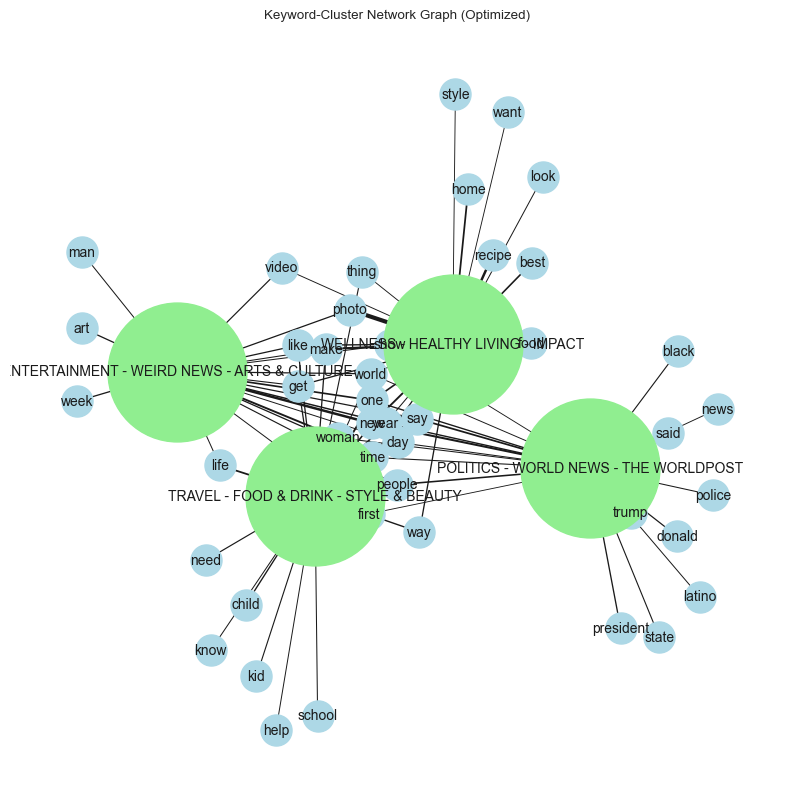

In [1088]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 10))
G = nx.Graph()
G.clear()

for keyword, associations in keyword_cluster_association.items():
    G.add_node(keyword, type='keyword')
    for cluster_name in set(dominant_categories):
        score = associations.get(cluster_name)
        if score is not None and score > 0.05:
            G.add_edge(keyword, cluster_name, weight=score)


for cluster_name in set(dominant_categories):
    G.add_node(cluster_name, type='cluster')

num_clusters = len(set(dominant_categories))
x_start = -10
x_end = 100
x_positions = np.linspace(x_start, x_end, num_clusters)
y_positions = [20 + 2*i if i%2 == 0 else 2*i for i in range(num_clusters)]

cluster_positions = {
    cluster_name: (x, y)
    for cluster_name, x, y in zip(set(dominant_categories), x_positions, y_positions)
}

fixed_positions = cluster_positions

fixed_nodes = list(cluster_positions.keys())


pos = nx.spring_layout(G, k=5, iterations=300, scale=10, pos=fixed_positions, fixed=fixed_nodes)
keyword_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'keyword']
cluster_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'cluster']

nx.draw_networkx_nodes(G, pos, nodelist=keyword_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=cluster_nodes, node_color='lightgreen', node_size=10000)
nx.draw_networkx_edges(G, pos, width=[d["weight"] * 10 for u, v, d in G.edges(data=True)])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Keyword-Cluster Network Graph (Optimized)')
plt.axis('off')
plt.show()

## Visualize Category Clusterization

In [1036]:
import plotly.graph_objects as go

size_scale_factor = 30
marker_sizes = np.array(category_dominance_scores) * size_scale_factor

fig = go.Figure(
    data=[go.Scatter3d(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        z=reduced_data[:, 2],
        mode='markers',
        marker=dict(
            size=marker_sizes,
            color=kmeans_results.labels_,
            colorscale='Rainbow',
            symbol='circle',
        ),
        text=category_names,
        textposition='top center',
    )],
    layout=go.Layout(
        width=1000,
        height=1200,
        scene=dict(
            xaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            yaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            zaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            xaxis_title='t-SNE Dimension 1',
            yaxis_title='t-SNE Dimension 2',
            zaxis_title='t-SNE Dimension 3',
        ),
        title='K-Means Clustering Visualization with t-SNE'
    ),
)


fig.update_traces(mode='markers+text')

fig.show()

In [1001]:
def map_to_cluster(category):
    sub_cat_idx = articles_by_category[articles_by_category['category'] == category].index[0]
    cluster_idx = kmeans_results.labels_[sub_cat_idx]
    return dominant_categories[cluster_idx]

y_train['cluster_category'] = y_train['category'].map(map_to_cluster).astype(str)
y_test['cluster_category'] = y_test['category'].map(map_to_cluster).astype(str)

In [1019]:
%%capture
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(vectorizer, MultinomialNB())

model.fit(x_train, y_train['cluster_category'])

In [1012]:
labels = model.predict(x_test)

In [1013]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

category_names = pd.unique(y_train['cluster_category'])
print(classification_report(y_test['cluster_category'], labels, target_names=dominant_categories))
mat = confusion_matrix(y_test['cluster_category'], labels, labels=dominant_categories)
f1_score_result = f1_score(y_test['cluster_category'], labels, average='micro')

                                             precision    recall  f1-score   support

ENTERTAINMENT - WEIRD NEWS - ARTS & CULTURE       0.69      0.63      0.66     10125
      POLITICS - WORLD NEWS - THE WORLDPOST       0.78      0.78      0.78     12117
         WELLNESS - HEALTHY LIVING - IMPACT       0.73      0.80      0.76     13170
     TRAVEL - FOOD & DRINK - STYLE & BEAUTY       0.80      0.72      0.76      6494

                                   accuracy                           0.74     41906
                                  macro avg       0.75      0.73      0.74     41906
                               weighted avg       0.74      0.74      0.74     41906



Overall F1 Score: 74.29%


Text(47.74999999999998, 0.5, 'predicted label')

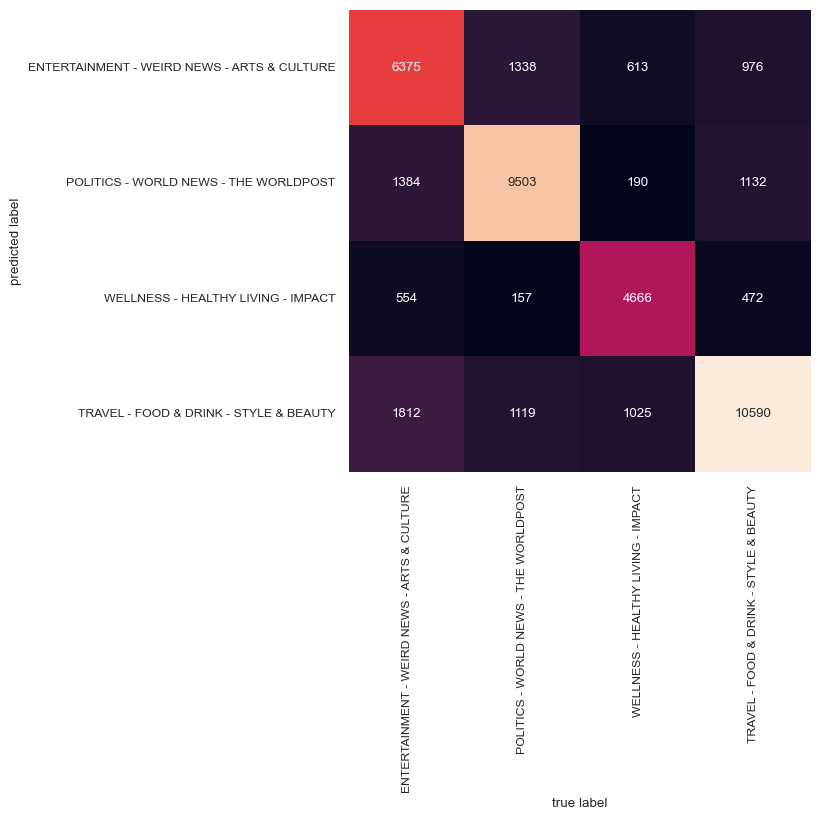

In [1014]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(threshold=1000)

print('Overall F1 Score: {:.2%}'.format(f1_score_result))

plt.rcParams.update({'font.size': 8, 'figure.figsize': [6, 6]})
sns.set_theme(font_scale=0.8)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=dominant_categories, yticklabels=dominant_categories)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [1008]:
headline = input('Enter a headline')
pred = model.predict([headline])
print('The headline "' + headline + '" is in the category ' + pred[0])

The headline "Instagram Debuts New Video-Editing App, as TikTok Deals With a Ban" is in the category ENTERTAINMENT - WEIRD NEWS - ARTS & CULTURE
